# Goal: segment muscles further from prediction images

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
#matplotlib figure size
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
from custom_imports import *

In [2]:
files = glob.glob("../data/images_with_predictions_v06/*data")
len(files)

832

FileNotFoundError: [Errno 2] No such file or directory: '../data/data/images_with_predictions_v06/4-FCWM3-14_16RepPreRaw.data'

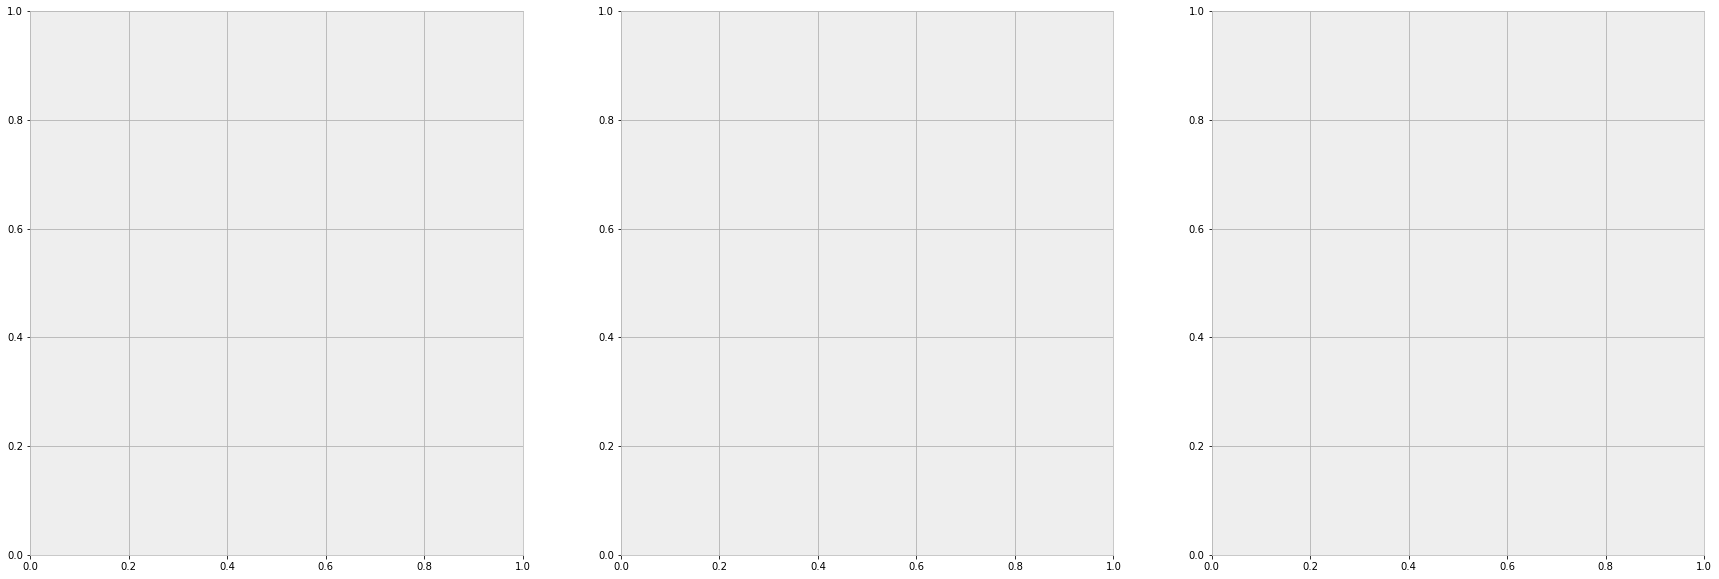

In [284]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
file = np.random.choice(files)
file = "../data/data/images_with_predictions_v05/4-FCWM3-14_16RepPreRaw.data"
# ../data/images_with_predictions_v04/4-CO1-22:50ConRaw.data
# file = "../data/images_with_predictions_v04/4-COF2B-21:50ConRaw.data"
# file = "../data/images_with_predictions_v04/3-COF5B-17:50ConRaw.data"
data = joblib.load(file)
axes[0].imshow(data.raw_image)
axes[1].imshow(data.traced_multilabel_mask)
axes[2].imshow(data.predicted)
print(file)
assert data.has_good_prediction()

In [274]:
# muscle_class = np.random.choice(classes)
# print(muscle_class)
# masked_muscle = data.raw_image.mean(axis=2) * (data.predicted==muscle_class)
# plt.imshow(masked_muscle)

## 1- Using Clustering

In [275]:
from mri_project.post_process import cluster_masked_muscle, post_mus_from_multiclass_mask
from mri_project.pipeline import get_largest_contour_of_each_color

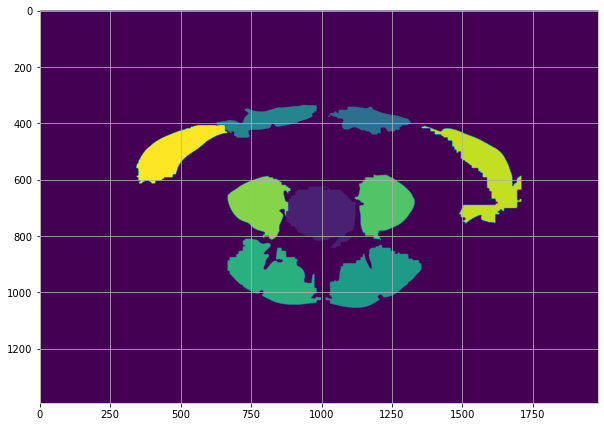

In [33]:
classes = sorted(np.unique(data.predicted))[1:]
out = np.zeros_like(data.predicted)
gray_raw_image = data.raw_image.mean(axis=2)
for cls in classes:
    mask = data.predicted==cls
    tmp_ = post_mus_from_multiclass_mask(gray_raw_image, mask, nclusters=2)
    muscle_mean    = (gray_raw_image[tmp_.astype(bool)]).mean()
    nonmuscle_mean = (gray_raw_image[(mask-tmp_).astype(bool)]).mean()
    nonmuscle_std = (gray_raw_image[(mask-tmp_).astype(bool)]).std()
    if muscle_mean > nonmuscle_mean + nonmuscle_std/6:
        tmp_ = (1 - tmp_)*mask
    out += tmp_ * cls
plt.imshow(get_largest_contour_of_each_color(out))

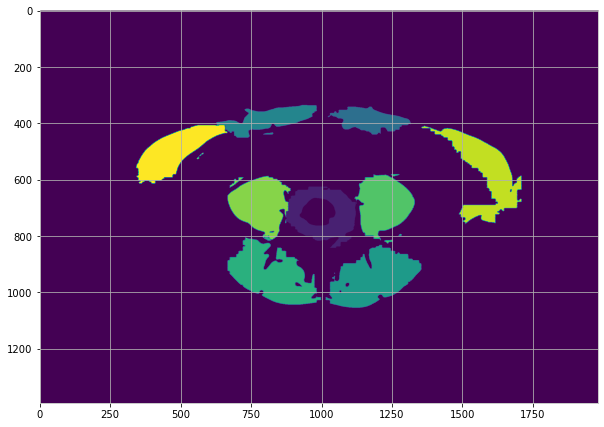

In [36]:
from mri_project.post_process import segment_mus_from_labels, muscle_mean_thresh
gray_raw_image = data.raw_image.mean(axis=2)
tmp_ = segment_mus_from_labels(gray_raw_image, data.predicted, post_mus_from_multiclass_mask, nclusters=2)
plt.imshow(tmp_)

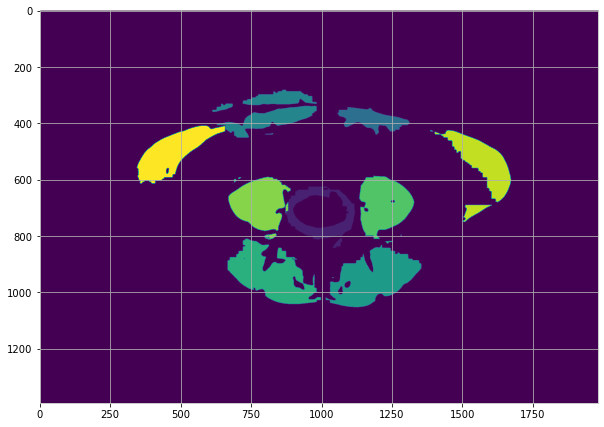

In [37]:
from mri_project.post_process import segment_mus_from_labels, muscle_mean_thresh
gray_raw_image = data.raw_image.mean(axis=2)
tmp_ = segment_mus_from_labels(gray_raw_image, data.predicted, post_mus_from_multiclass_mask, nclusters=3)
plt.imshow(tmp_)

## 2- Using simple thresholding below mean

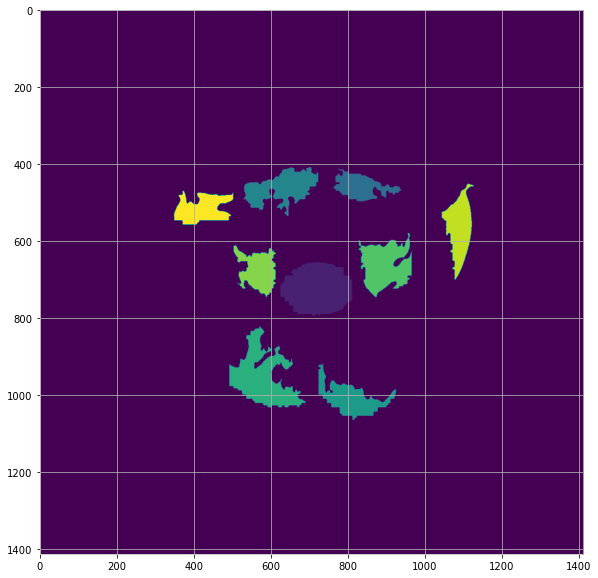

In [282]:
classes = sorted(np.unique(data.predicted))[1:]
out = np.zeros_like(data.predicted)
gray_raw_image = cv2.equalizeHist(np.uint8(data.raw_image.mean(axis=2)))
for cls in classes:
    # mask = data.predicted==cls
    mask = data.predicted==cls
    # tmp_ = segment_mus_from_pred(gray_raw_image, mask, nclusters=3)
    mean_ = gray_raw_image[mask].mean()
    std_ = gray_raw_image[mask].std()
    # muscle_mean    = (tmp_*gray_raw_image).mean()
    # nonmuscle_mean = ((mask-tmp_)*gray_raw_image).mean()
    # nonmuscle_std = ((mask-tmp_)*gray_raw_image).std()
    # if muscle_mean > nonmuscle_mean + nonmuscle_std/6:
    #     tmp_ = (1 - tmp_)*mask
    out +=  (gray_raw_image < mean_+std_/5) * cls * mask
plt.imshow(get_largest_contour_of_each_color(out))

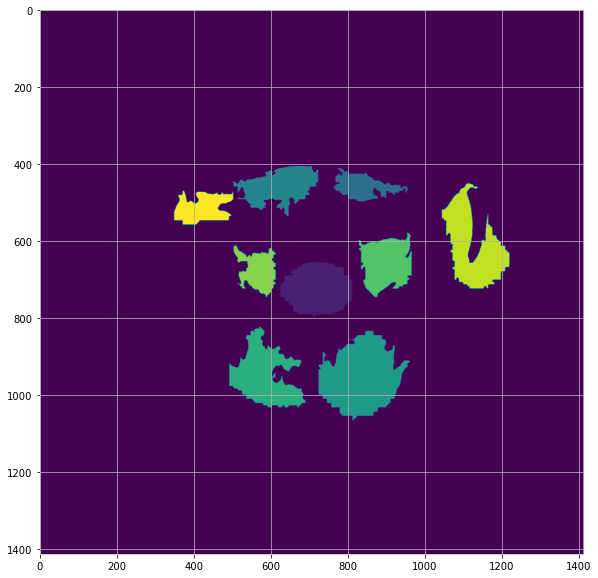

In [283]:
from mri_project.post_process import segment_mus_from_labels, muscle_mean_thresh
gray_raw_image = data.raw_image.mean(axis=2)
tmp_ = segment_mus_from_labels(gray_raw_image, data.predicted, muscle_mean_thresh, std_ratio=1/5)
plt.imshow(get_largest_contour_of_each_color(tmp_))

## 3- Using percentiles as thresholds

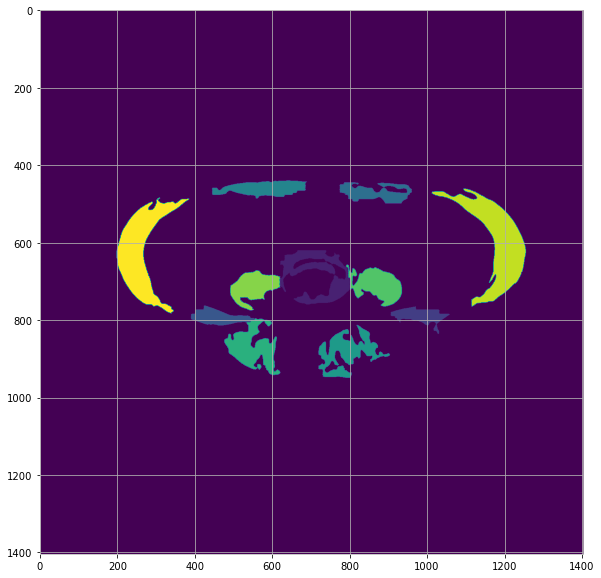

In [603]:
classes = sorted(np.unique(data.predicted))[1:]
out = np.zeros_like(data.predicted)
gray_raw_image = data.raw_image.mean(axis=2)
for cls in classes:
    mask = data.predicted==cls
    # tmp_ = segment_mus_from_pred(gray_raw_image, mask, nclusters=3)
    p_ = np.percentile(gray_raw_image[mask], 45)
    # muscle_mean    = (tmp_*gray_raw_image).mean()
    # nonmuscle_mean = ((mask-tmp_)*gray_raw_image).mean()
    # nonmuscle_std = ((mask-tmp_)*gray_raw_image).std()
    # if muscle_mean > nonmuscle_mean + nonmuscle_std/6:
    #     tmp_ = (1 - tmp_)*mask
    out +=  (gray_raw_image < p_) * cls * mask
plt.imshow(get_largest_contour_of_each_color(out))

## 4- Adaptive thresholding

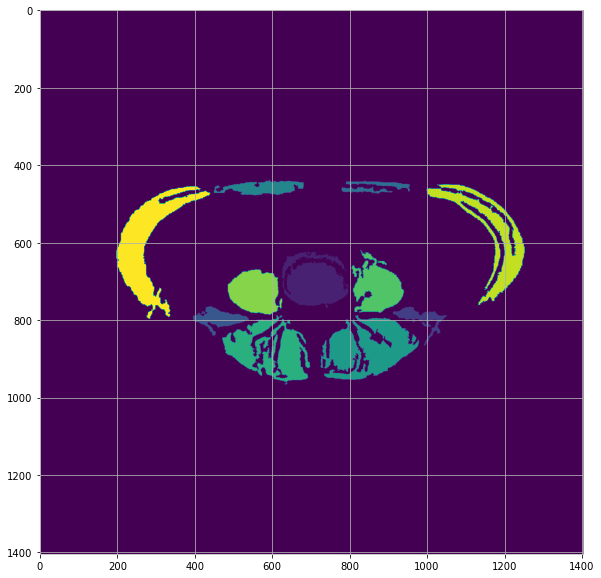

In [605]:
classes = sorted(np.unique(data.predicted))[1:]
out = np.zeros_like(data.predicted)
gray_raw_image = data.raw_image.mean(axis=2)
imt = np.uint8(255*(gray_raw_image-gray_raw_image.min())/(gray_raw_image.max()-gray_raw_image.min()))
for cls in classes:
    mask = data.predicted==cls
    tmp_ = cv2.adaptiveThreshold(imt*mask, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
    tmp_ = mask - tmp_
    tmp_ = cv2.erode(tmp_, np.ones((3, 3)))
    out += tmp_ * cls
plt.imshow(get_largest_contour_of_each_color(out))

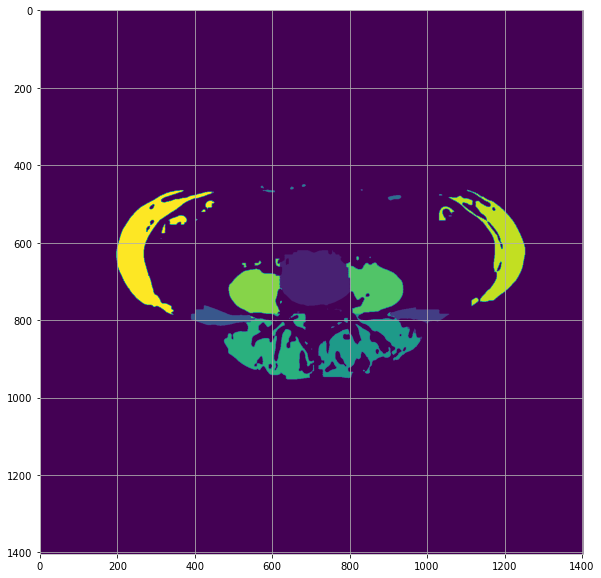

In [610]:
tmp_ = gray_raw_image < gray_raw_image.mean()
tmp2_ = (gray_raw_image > gray_raw_image[tmp_].mean()) & tmp_
# tmp3_ = (gray_raw_image < gray_raw_image[tmp2_].mean()) & tmp2_
plt.imshow(tmp2_ * data.predicted)

In [586]:
mask = data.predicted == 11
imt = np.uint8(255*(gray_raw_image-gray_raw_image.min())/(gray_raw_image.max()-gray_raw_image.min()))
# plt.imshow(get_largest_contour_of_each_color(out))
h, w = imt.shape[:2]
out = np.zeros((h + 2, w + 2), np.uint8)
mardas = np.zeros((h + 2, w + 2), np.uint8)
indices = np.array(np.where(mask))
for i in range(500):
# center = np.int32(indices.mean(axis=1))
    center = indices.T[np.random.randint(len(indices.T))]
    diff = np.random.randint(10)
    cv2.floodFill(imt.copy(), mardas, tuple(center)[::-1], 1, diff, diff, flags = cv2.FLOODFILL_FIXED_RANGE)
    out += mardas
out = out[1:-1, 1:-1]

In [587]:
# plt.imshow(get_largest_contour_of_each_color(out))

In [66]:
args = np.argsort(np.bincount((out*mask).reshape(-1)))
print(args)
tmp_ = np.uint8(out > args[-20])
tmp_1 = cv2.erode(tmp_, np.ones((30, 30)))
tmp_2 = cv2.dilate(tmp_1, np.ones((30, 30)))
plt.imshow(tmp_2)

[ 1  2  3  4  5  6  7  8  9 10 11  0]


IndexError: index -20 is out of bounds for axis 0 with size 12

In [2]:
from mri_project.utility import imsshow

../data/data/images_with_predictions_v07/1-COM2B-3_16PostRaw.data


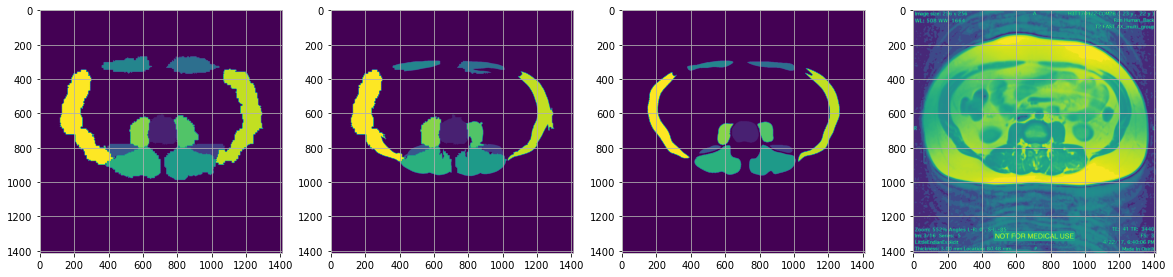

In [216]:
files = glob.glob("../data/data/images_with_predictions_v07/*")
file = np.random.choice(files)
# file = "../data/data/images_with_predictions_v05/1-WM2B-3_16PostRaw.data"
# file = "../data/data/images_with_predictions_v06/1-WM3B-3_16PostRaw.data"
# file = "../data/data/images_with_predictions_v05/1-CO5-3_16RepPreRaw.data"
print(file)
data_ = joblib.load(file)
fig, axes = imsshow(
    data_.predicted,
    data_.predicted_postprocessed,
    data_.traced_multilabel_mask,
    cv2.equalizeHist(np.uint8(data_.raw_image.mean(axis=2))), 
    single_size=(20, 20),
)
assert data_.has_good_prediction()

73265 5771


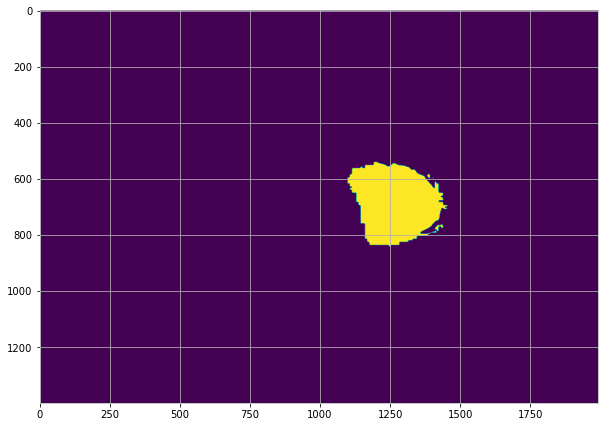

In [196]:
from mri_project.post_process import muscle_outlier_thresh
gray_ = cv2.equalizeHist(np.uint8(data_.raw_image.mean(axis=2)))
mask_ = data_.predicted == np.random.choice(range(1, 12))
# plt.imshow(np.logical_xor(data_.predicted, muscle_outlier_thresh(gray_, mask_, 1.5)))
plt.imshow(muscle_outlier_thresh(gray_, mask_, 1.5))

In [150]:
from mri_project.utility import *
data_.raw_image.mean(axis=2)[data_.predicted == 7]

array([ 47.,  48.,  48., ..., 211., 211., 215.])

In [103]:
m9 = tf.keras.models.load_model("../data/models/new_era.v02.9muscles.h5")
m11 = tf.keras.models.load_model("../data/models/new_era.v03.11muscles.h5")

In [112]:
def predict_image(model, x):
    gray = x
    if len(x.shape) == 3 and x.shape[-1] == 3:
        gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray, (256, 256))
    normalized_image = (resized_image - resized_image.mean()) / resized_image.std()
    inp = normalized_image.reshape(1, *normalized_image.shape, 1)
    prediction = model.predict(inp)
    # res = prediction.argmax(axis=3)[0].astype('uint8')
    # resized_res = resize_muscle_image(res, x.shape[:2][::-1])
    # cleaned_res = get_largest_contour_of_each_color(resized_res)
    return prediction

probs = predict_image(m11, data_.raw_image)[0]

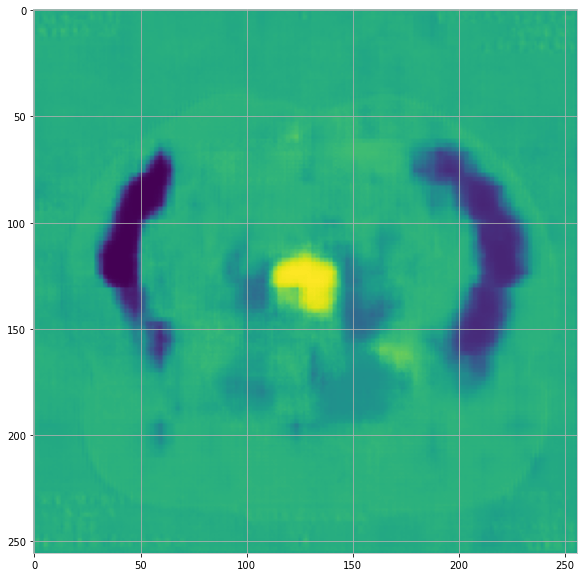

In [136]:
# plt.imshow(np.argmax(probs, axis=3)[0])
# plt.imshow(np.argmax(np.where(probs < .1, 0, probs), axis=2))
# plt.imshow((probs * np.arange(12)[::-1].reshape(1, 1, -1)).mean(axis=2))

In [225]:
from sklearn.cluster import KMeans


In [229]:
model = KMeans(2)
d_ = data.raw_image.mean(axis=2)[data.predicted == 9].reshape(-1, 1)
model.fit(d_)

KMeans(n_clusters=2)

In [231]:
pd_ = model.transform(d_)

In [237]:
((pd_[:, 0] / pd_[:, 1])>1.1).sum()

9539

In [239]:
KMeans()

0.0001